# Benchmark models

[Forecasting with Machine Learning - Course](https://www.trainindata.com/p/forecasting-with-machine-learning)

In this notebook, we will predict energy demand in the next hour using simple forecasting models, to obtain a benchmark against which we can test our machine learning models later on.

We will use:

- Naive forecasting
- Seasonal forecasting
- Moving average forecasting
- Historical average forecasting


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import mean_squared_error

# Load data

We will use the electricity demand dataset found [here](https://github.com/tidyverts/tsibbledata/tree/master/data-raw/vic_elec/VIC2015).

**Citation:**

Godahewa, Rakshitha, Bergmeir, Christoph, Webb, Geoff, Hyndman, Rob, & Montero-Manso, Pablo. (2021). Australian Electricity Demand Dataset (Version 1) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.4659727

**Description of data:**

A description of the data can be found [here](https://rdrr.io/cran/tsibbledata/man/vic_elec.html). The data contains electricity demand in Victoria, Australia, at 30 minute intervals over a period of 12 years, from 2002 to early 2015. There is also the temperature in Melbourne at 30 minute intervals and public holiday dates.

In [2]:
# Electricity demand.
url = "https://raw.githubusercontent.com/tidyverts/tsibbledata/master/data-raw/vic_elec/VIC2015/demand.csv"
df = pd.read_csv(url)

df.drop(columns=["Industrial"], inplace=True)

# Convert the integer Date to an actual date with datetime type
df["date"] = df["Date"].apply(
    lambda x: pd.Timestamp("1899-12-30") + pd.Timedelta(x, unit="days")
)

# Create a timestamp from the integer Period representing 30 minute intervals
df["date_time"] = df["date"] + \
    pd.to_timedelta((df["Period"] - 1) * 30, unit="m")

df.dropna(inplace=True)

# Rename columns
df = df[["date_time", "OperationalLessIndustrial"]]

df.columns = ["date_time", "demand"]

# Resample to hourly
df = (
    df.set_index("date_time")
    .resample("H")
    .agg({"demand": "sum"})
)

df.head()

,demand
date_time,
2002-01-01 00:00:00,6919.366092
2002-01-01 01:00:00,7165.974188
2002-01-01 02:00:00,6406.542994
2002-01-01 03:00:00,5815.537828
2002-01-01 04:00:00,5497.732922


## Naive forecasting

We predict the next value as its immediate value in the past.

In [3]:
df["naive"] = df["demand"].shift(periods=1)

df.head()

,demand,naive
date_time,,
2002-01-01 00:00:00,6919.366092,NaN
2002-01-01 01:00:00,7165.974188,6919.366092
2002-01-01 02:00:00,6406.542994,7165.974188
2002-01-01 03:00:00,5815.537828,6406.542994
2002-01-01 04:00:00,5497.732922,5815.537828


We are doing single step ahead forecasting. In this scenario, we know the value in the past at the point of forecast.

## Seasonal naive forecasting

We predict the next value as its value a season ago. We know that the time series shows weekly seasonality. That means that the energy consumption each Tuesday at 9 am is more or less the same.

We can predict next Tuesday at 9 am using last Tuesday's value at 9 am

In [4]:
# Predict energy consumption as its value exactly one week behind.

freq = "7d"
df["seasonal"] = df["demand"].shift(freq=freq)

df.head()

,demand,naive,seasonal
date_time,,,
2002-01-01 00:00:00,6919.366092,NaN,NaN
2002-01-01 01:00:00,7165.974188,6919.366092,NaN
2002-01-01 02:00:00,6406.542994,7165.974188,NaN
2002-01-01 03:00:00,5815.537828,6406.542994,NaN
2002-01-01 04:00:00,5497.732922,5815.537828,NaN


In [5]:
# to corroborate the values

df.loc["2002-01-08 00:00:00":].head()

,demand,naive,seasonal
date_time,,,
2002-01-08 00:00:00,7077.081904,7406.047910,6919.366092
2002-01-08 01:00:00,7445.354310,7077.081904,7165.974188
2002-01-08 02:00:00,6800.577478,7445.354310,6406.542994
2002-01-08 03:00:00,6340.914086,6800.577478,5815.537828
2002-01-08 04:00:00,6277.978250,6340.914086,5497.732922


## Moving average

We predict the next value as the average of the last 3 values.

I don't think this is a good method for this particular time series, but we'll do it just to demo how it works.

In [6]:
# We'll use a 3H window size.

result = (
    df["demand"]
    .rolling(window=3)  # Pick window size.
    .agg(["mean"])  # Pick statistics.
    .shift(freq="1H")  # Lag by 1 hour to avoid data leakage.
)

result.columns = ["moving_ave"]

# add features to main dataframe

df = df.merge(result, how="left", left_index=True, right_index=True)

df.head()

,demand,naive,seasonal,moving_ave
date_time,,,,
2002-01-01 00:00:00,6919.366092,NaN,NaN,NaN
2002-01-01 01:00:00,7165.974188,6919.366092,NaN,NaN
2002-01-01 02:00:00,6406.542994,7165.974188,NaN,NaN
2002-01-01 03:00:00,5815.537828,6406.542994,NaN,6830.627758
2002-01-01 04:00:00,5497.732922,5815.537828,NaN,6462.685003


## Historical

We predict future values as the mean of all values in the past.

Again, I don't think this is a good method for this particular time series, but we'll do it to demo how it works.

In [7]:
result = (
    df["demand"]
    .expanding()  # all values in the past.
    .agg(["mean"])  # Pick statistics.
    .shift(freq="1H")  # Lag by 1 hour to avoid data leakage.
)

result.columns = ["historical_ave"]

# add features to main dataframe
df = df.merge(result, how="left", left_index=True, right_index=True)

df.head()

,demand,naive,seasonal,moving_ave,historical_ave
date_time,,,,,
2002-01-01 00:00:00,6919.366092,NaN,NaN,NaN,NaN
2002-01-01 01:00:00,7165.974188,6919.366092,NaN,NaN,6919.366092
2002-01-01 02:00:00,6406.542994,7165.974188,NaN,NaN,7042.670140
2002-01-01 03:00:00,5815.537828,6406.542994,NaN,6830.627758,6830.627758
2002-01-01 04:00:00,5497.732922,5815.537828,NaN,6462.685003,6576.855276


In [8]:
# Let's drop all those rows where we don't have forecasts

df.dropna(inplace=True)

df.head()

,demand,naive,seasonal,moving_ave,historical_ave
date_time,,,,,
2002-01-08 00:00:00,7077.081904,7406.047910,6919.366092,7003.111898,7095.013652
2002-01-08 01:00:00,7445.354310,7077.081904,7165.974188,7053.973603,7094.907547
2002-01-08 02:00:00,6800.577478,7445.354310,6406.542994,7309.494708,7096.968999
2002-01-08 03:00:00,6340.914086,6800.577478,5815.537828,7107.671231,7095.235715
2002-01-08 04:00:00,6277.978250,6340.914086,5497.732922,6862.281958,7090.850124


## Benchmark performance

We'll split the data and evaluate the benchmark models on the test set.

For these benchmark models, splitting the data into train and test is not so important. 

But we want to use the same procedure that we will use for machine learning models in the next notebook, so that we can compare the results.

In [9]:
# Split into train and test

# We leave 2015 in the test set

end_train = '2014-12-31 23:59:59'
X_train = df.loc[:end_train]
X_test  = df.loc[end_train:]

In [10]:
# The different basic forecasts

df.columns[1:]

Index(['naive', 'seasonal', 'moving_ave', 'historical_ave'], dtype='object')

In [11]:
# Determine the error in the test set
# for each forecast

for column in df.columns[1:]:    

    target = X_test["demand"]
    preds = X_test[column]

    rmse = mean_squared_error(target, preds, squared=False)

    print(f"performance of {column} = {np.round(rmse, 0)}")

performance of naive = 499.0
performance of seasonal = 1857.0
performance of moving_ave = 851.0
performance of historical_ave = 1803.0


From these basic forecasts, the **naive forecast** is the best for this particular time series. 

We could of course try different seasonal patterns or windows for the moving average, but I'll leave that with you.

## Plot benchmark predictions

We will now overlay the predictions over the real values of the time series.

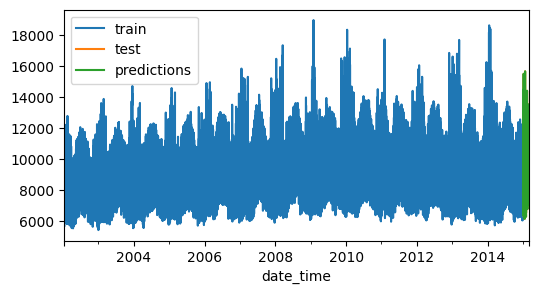

In [12]:
fig, ax = plt.subplots(figsize=(6, 3))
X_train["demand"].plot(ax=ax, label='train')
X_test["demand"].plot(ax=ax, label='test')
X_test["naive"].plot(ax=ax, label='predictions')
ax.legend();

Too many points, we can't see anything. 

Let's limit the plot to 100 points:

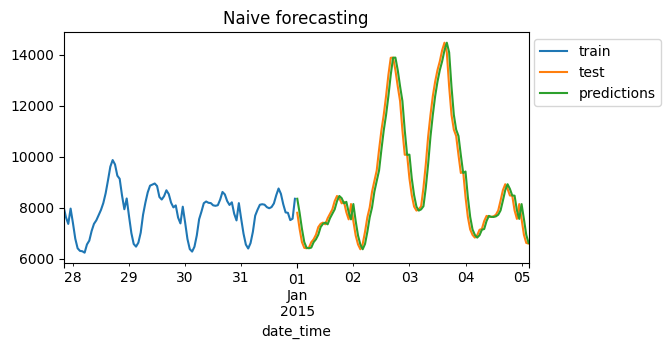

In [13]:
fig, ax = plt.subplots(figsize=(6, 3))
X_train.iloc[-100:]["demand"].plot(ax=ax, label='train')
X_test.iloc[:100]["demand"].plot(ax=ax, label='test')
X_test.iloc[:100]["naive"].plot(ax=ax, label='predictions')
plt.title("Naive forecasting")
ax.legend(bbox_to_anchor=(1.3, 1.0));

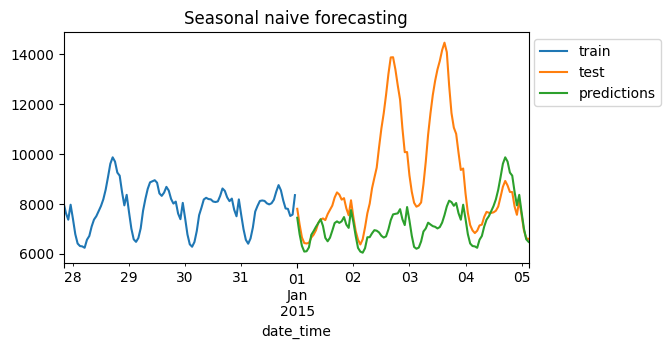

In [14]:
fig, ax = plt.subplots(figsize=(6, 3))
X_train.iloc[-100:]["demand"].plot(ax=ax, label='train')
X_test.iloc[:100]["demand"].plot(ax=ax, label='test')
X_test.iloc[:100]["seasonal"].plot(ax=ax, label='predictions')
plt.title("Seasonal naive forecasting")
ax.legend(bbox_to_anchor=(1.3, 1.0));

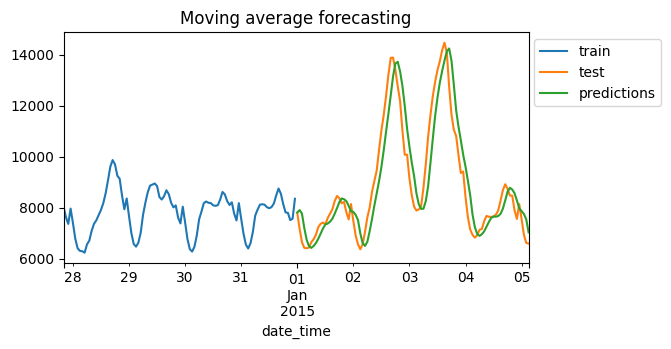

In [15]:
fig, ax = plt.subplots(figsize=(6, 3))
X_train.iloc[-100:]["demand"].plot(ax=ax, label='train')
X_test.iloc[:100]["demand"].plot(ax=ax, label='test')
X_test.iloc[:100]["moving_ave"].plot(ax=ax, label='predictions')
plt.title("Moving average forecasting")
ax.legend(bbox_to_anchor=(1.3, 1.0));

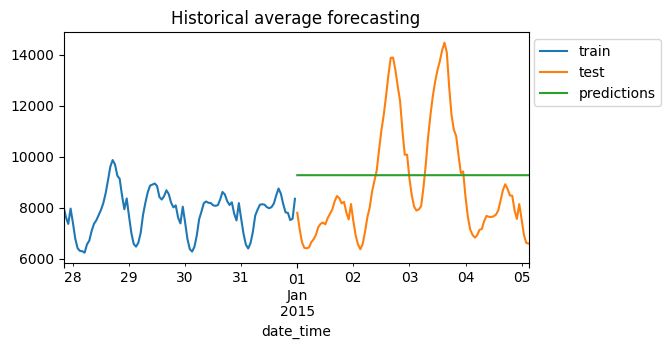

In [16]:
fig, ax = plt.subplots(figsize=(6, 3))
X_train.iloc[-100:]["demand"].plot(ax=ax, label='train')
X_test.iloc[:100]["demand"].plot(ax=ax, label='test')
X_test.iloc[:100]["historical_ave"].plot(ax=ax, label='predictions')
plt.title("Historical average forecasting")
ax.legend(bbox_to_anchor=(1.3, 1.0));